In [51]:
import numpy as np
from math import factorial, sqrt
from math import lgamma, exp, sqrt
from collections import defaultdict
from functools import lru_cache

# ---------------------------
# Numeric symmetric basis
# ---------------------------
def sym_basis_k_numeric(k, d=3):
    basis = []

    def generate(remain, parts):
        if len(parts) == d - 1:
            parts = parts + [remain]
            # Use log factorial to avoid overflow
            log_num = sum(lgamma(p + 1) for p in parts)  # log(p!)
            log_den = lgamma(k + 1)                     # log(k!)
            norm = sqrt(exp(log_num - log_den))
            basis.append((tuple(parts), norm))
            return
        for i in range(remain, -1, -1):
            generate(remain - i, parts + [i])

    generate(k, [])
    return basis

# ---------------------------
# Numeric contingency enumeration
# ---------------------------
def enumerate_contingency_matrices(rows, cols):
    d = len(rows)
    assert len(cols) == d
    assert sum(rows) == sum(cols)

    @lru_cache(maxsize=None)
    def _recurse(row_idx, cols_remaining):
        cols_remaining = list(cols_remaining)
        if row_idx == d:
            if all(c == 0 for c in cols_remaining):
                return [()]
            else:
                return []
        results = []
        target = rows[row_idx]

        def compose(pos, left, current):
            if pos == d - 1:
                val = left
                if val <= cols_remaining[pos]:
                    yield tuple(current + [val])
                return
            maxv = min(left, cols_remaining[pos])
            for v in range(maxv, -1, -1):
                yield from compose(pos + 1, left - v, current + [v])

        for row_choice in compose(0, target, []):
            new_cols = tuple(cols_remaining[j] - row_choice[j] for j in range(d))
            for tail in _recurse(row_idx + 1, new_cols):
                results.append(tuple(row_choice) + tail)
        return results

    for mat_flat in _recurse(0, tuple(cols)):
        yield mat_flat

# ---------------------------
# Numeric symmetric projection
# ---------------------------
def pi_symmetric_multinomial_numeric(M, basis):
    M = np.array(M, dtype=float)
    d = M.shape[0]
    n = len(basis)
    piM = np.zeros((n, n))

    # Precompute factorials up to max k
    max_k = max(sum(vec) for vec, _ in basis)
    factorials = [factorial(i) for i in range(max_k + 1)]
    inv_factorials = [1.0 / factorials[i] for i in range(max_k + 1)]

    # Precompute M powers but flattened by pos = u*d + v
    # powers_flat[pos] = [M_pos^0, M_pos^1, ..., M_pos^max_k]
    powers_flat = {}
    for u in range(d):
        for v in range(d):
            pos = u * d + v
            arr = [1.0]
            val = 1.0
            mval = float(M[u, v])
            for t in range(1, max_k + 1):
                val *= mval
                arr.append(val)
            powers_flat[pos] = arr

    # Group basis by total degree k
    basis_by_k = defaultdict(list)
    for idx, (vec, norm) in enumerate(basis):
        k = sum(vec)
        basis_by_k[k].append((idx, tuple(vec), norm))

    # Cache for contingency matrices (canonical keys)
    cm_cache = {}

    # Precompute positions list for iteration (pos 0..d*d-1)
    positions = list(range(d * d))

    # Compute projection
    for k_val, group in basis_by_k.items():
        k_fact = factorials[k_val]
        # Bind local references for speed
        powers_local = powers_flat
        inv_fact_local = inv_factorials
        d_local = d
        for i_idx, vec_i, norm_i in group:
            for j_idx, vec_j, norm_j in group:
                key = (vec_i, vec_j)
                if key not in cm_cache:
                    # ensure we pass tuples to the enumerator/caching
                    cm_cache[key] = list(enumerate_contingency_matrices(vec_i, vec_j))

                mats = cm_cache[key]

                val = 0.0
                # Localize k_fact to avoid global lookup
                kfact_local = k_fact
                for mat_flat in mats:
                    term = 1.0
                    denom_inv = 1.0  # will accumulate product of 1/factorial[t]
                    # iterate flattened positions (single loop instead of nested u,v)
                    for pos, t in enumerate(mat_flat):
                        if t:
                            term *= powers_local[pos][t]
                            denom_inv *= inv_fact_local[t]
                    val += kfact_local * denom_inv * term

                piM[i_idx, j_idx] = norm_i * norm_j * val

    return piM
if __name__ == "__main__":
    d = 3
    k_val = 25
    M = [[1.0, 2.0, 3.0],
         [4.0, 5.0, 6.0],
         [7.0, 8.0, 9.0]]

    basis = sym_basis_k_numeric(k_val, d)
    piM = pi_symmetric_multinomial_numeric(M, basis)
    print(piM)


[[1.00000000e+00 1.00000000e+01 1.50000000e+01 ... 6.52243076e+12
  2.82429536e+12 8.47288609e+11]
 [2.00000000e+01 1.97000000e+02 2.94000000e+02 ... 6.65287937e+13
  2.85253832e+13 8.47288609e+12]
 [3.50000000e+01 3.44000000e+02 5.13000000e+02 ... 1.00445434e+14
  4.29292895e+13 1.27093291e+13]
 ...
 [7.58464975e+21 4.36659121e+22 4.94085755e+22 ... 7.48750860e+25
  2.44388861e+25 5.52638129e+24]
 [3.83162463e+21 2.19771041e+22 2.47960851e+22 ... 3.25851815e+25
  1.06089369e+25 2.39299329e+24]
 [1.34106862e+21 7.66324926e+21 8.62115541e+21 ... 9.82467784e+24
  3.19065772e+24 7.17897988e+23]]


In [29]:
import cProfile
import pstats

profiler = cProfile.Profile()
profiler.enable()

# run the code you want to profile
piM = pi_symmetric_multinomial_numeric(M, basis)

profiler.disable()
stats = pstats.Stats(profiler).sort_stats("cumulative")
stats.print_stats(20)  # print top 20 functions by cumulative time

         8462752 function calls (8462748 primitive calls) in 17.119 seconds

   Ordered by: cumulative time
   List reduced from 130 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        3    0.000    0.000    9.651    3.217 c:\Users\martin\anaconda3\Lib\asyncio\base_events.py:1962(_run_once)
        3    0.000    0.000    9.651    3.217 c:\Users\martin\anaconda3\Lib\selectors.py:310(select)
        3    0.000    0.000    9.651    3.217 c:\Users\martin\anaconda3\Lib\selectors.py:304(_select)
        3    7.931    2.644    9.651    3.217 {built-in method select.select}
        2    0.000    0.000    7.347    3.673 c:\Users\martin\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3541(run_code)
        2    0.000    0.000    7.347    3.673 {built-in method builtins.exec}
        1    0.000    0.000    7.347    7.347 C:\Users\martin\AppData\Local\Temp\ipykernel_15152\879628236.py:1(<module>)
        1    6.076    6.076   

In [47]:
import numpy as np
import random

# Assume these functions are already defined:
# - sym_basis_k_numeric
# - pi_symmetric_multinomial_numeric

def random_float_matrix(d, lo=-3, hi=3):
    """Generate a random d x d numeric matrix (float)."""
    return np.array([[random.randint(lo, hi) for _ in range(d)] for _ in range(d)], dtype=float)

def test_numeric_representation_property(d=3, k_val=4, trials=3, rtol=1e-12, atol=1e-12):
    """
    Test the representation property π(AB) = π(A) π(B) numerically for S^k(ℂ^d).
    """
    print(f"Testing numeric π(AB) = π(A) π(B) for S^{k_val}(ℂ^{d}) ...\n")

    basis = sym_basis_k_numeric(k_val, d)

    for t in range(trials):
        print(f"--- Trial {t+1} ---")

        # Random numeric matrices
        A = random_float_matrix(d)
        B = random_float_matrix(d)
        AB = A @ B

        print("A =\n", A)
        print("B =\n", B)

        # Compute symmetric power matrices
        piA = pi_symmetric_multinomial_numeric(A, basis)
        piB = pi_symmetric_multinomial_numeric(B, basis)
        piAB = pi_symmetric_multinomial_numeric(AB, basis)

        # Compare using np.allclose for floating-point equality
        if np.allclose(piAB, piA @ piB, rtol=rtol, atol=atol):
            print("✅ PASS:  pi(AB) ≈ pi(A) * pi(B)\n")
        else:
            print("❌ FAIL!")
            print("piAB =\n", piAB)
            print("piA @ piB =\n", piA @ piB)
            print("Difference =\n", piAB - (piA @ piB))
            return False  # early stop

    print("All numeric tests passed ✅")
    return True

# Run the numeric test
if __name__ == "__main__":
    random.seed(0)
    np.random.seed(0)
    test_numeric_representation_property(d=3, k_val=4, trials=3)


Testing numeric π(AB) = π(A) π(B) for S^4(ℂ^3) ...

--- Trial 1 ---
A =
 [[ 3.  0.  3.]
 [ 0. -3. -1.]
 [ 1.  0.  0.]]
B =
 [[ 3.  3. -1.]
 [ 0. -1.  1.]
 [-2.  1. -2.]]
✅ PASS:  pi(AB) ≈ pi(A) * pi(B)

--- Trial 2 ---
A =
 [[-1. -2.  3.]
 [-3.  1.  3.]
 [-1.  1.  2.]]
B =
 [[ 3.  1. -2.]
 [-1. -3.  2.]
 [-3.  3.  2.]]
✅ PASS:  pi(AB) ≈ pi(A) * pi(B)

--- Trial 3 ---
A =
 [[-1.  0.  1.]
 [-3. -1.  0.]
 [-1.  1.  2.]]
B =
 [[-2.  1.  0.]
 [ 0.  3.  1.]
 [-1. -3.  3.]]
✅ PASS:  pi(AB) ≈ pi(A) * pi(B)

All numeric tests passed ✅


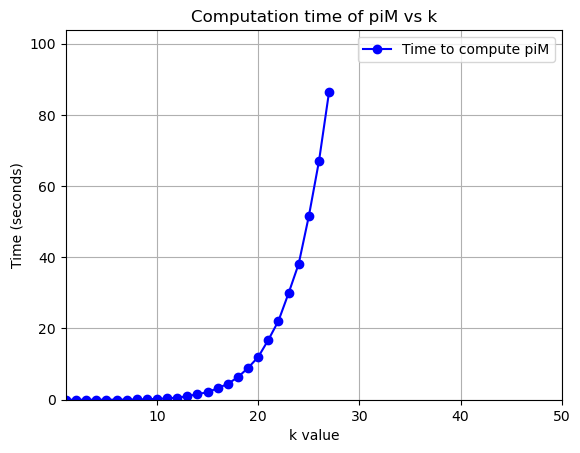

KeyboardInterrupt: 

In [56]:
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output

# Assume sym_basis_k_symbolic and pi_symmetric_multinomial are already defined
d = 3
M = [[1.0, 2.0, 3.0],
     [4.0, 5.0, 6.0],
     [7.0, 8.0, 9.0]]

k_values = list(range(1, 51))
times = []

plt.figure(figsize=(8,5))

for k_val in k_values:
    start = time.time()

    basis = sym_basis_k_numeric(k_val, d)
    piM = pi_symmetric_multinomial_numeric(M, basis)

    elapsed = time.time() - start
    times.append(elapsed)
    
    # Clear previous plot
    clear_output(wait=True)
    
    # Plot updated data
    plt.plot(k_values[:len(times)], times, 'o-', color='blue', label="Time to compute piM")
    plt.xlabel("k value")
    plt.ylabel("Time (seconds)")
    plt.title("Computation time of piM vs k")
    plt.grid(True)
    plt.legend()
    plt.xlim(1, 50)
    plt.ylim(0, max(times)*1.2)
    plt.show()